$\Huge{ \text{Calcul de la Value-at-Risk à l'aide des modèles GARCH :}} \\$ 

$\Huge{\text{Application au cours du BITCOIN}}$

<hr><b>
<hr><b>

$\huge{\text{Groupe KAGLAN KHABITIE KHENESSI}}$

## Imports and set up

##### Remarque : Le module arch est appellé dans les imports. Il faudra l'installer avec la commande !pip install arch 

In [44]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.collections import PolyCollection
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from arch.unitroot import ADF
plt.rcParams['figure.figsize']=(10,8)
plt.rc('axes', labelsize = 15)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.style.use('seaborn-whitegrid')

In [7]:
root = os.getcwd()
PROJECT_ROOT = os.path.join(root, 'DM_Figures')
os.makedirs(PROJECT_ROOT, exist_ok=True)
def save_fig(fig_id, tight_layout = True, fig_extention = 'pdf', resolution=300):
    path = os.path.join(PROJECT_ROOT, fig_id + '.' + fig_extention)
    print('Saving figure', fig_id, '\n\n')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extention, dpi =resolution)

# Introduction

### VaR : Illustration de la Value At Risk (VAR)

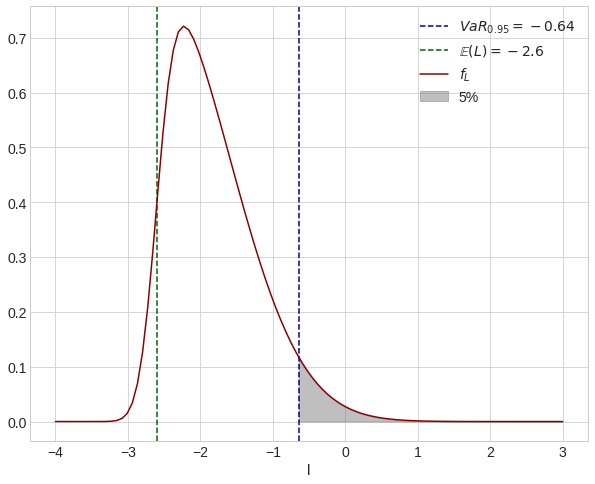

In [8]:
a = 5
x = np.linspace(-4, 3,100)
VaR = stats.skewnorm.ppf(0.95, a, loc=-2.6)
plt.axvline(x=VaR, color='darkblue', linestyle='dashed')
plt.axvline(x=-2.6, color='darkgreen', linestyle='dashed')
px=np.linspace(VaR,3 , 100)
plt.fill_between(px, stats.skewnorm.pdf(px, a,loc=-2.6 ), color='gray', alpha=0.5)
plt.xlabel('l')
plt.plot(x, stats.skewnorm.pdf(x,a, loc = -2.6), color='darkred')
plt.legend([r'$VaR_{0.95} = -0.64$', r'$\mathbb{E}(L) = -2.6$',r'$f_{L}$', '5%'], fontsize=14)
#save_fig('VaR')

In [9]:
VaR

-0.6400360154600486

# Data Exploration and Analysis

### Cours de Cloture du BITCOIN sur 10 ans (du 23-12-2011 au 23-12-2021 )

In [13]:
!wget https://minio.lab.sspcloud.fr/mawulikaglan/BTCEUR.txt
!ls

--2022-01-02 18:56:10--  https://minio.lab.sspcloud.fr/mawulikaglan/BTCEUR.txt
Resolving minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)... 192.168.253.152, 192.168.253.151
Connecting to minio.lab.sspcloud.fr (minio.lab.sspcloud.fr)|192.168.253.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176263 (172K) [binary/octet-stream]
Saving to: ‘BTCEUR.txt’

BTCEUR.txt          100%[===================>] 172.13K  --.-KB/s    in 0.003s  

2022-01-02 18:56:10 (58.7 MB/s) - ‘BTCEUR.txt’ saved [176263/176263]

 BTCEUR.txt	     'Notebook DataScience Project.ipynb'
 DM_Figures	     'Notebook DataScience Project - Webscrapping.ipynb'
 Modelisation.ipynb


#### Importation des données :

In [14]:
BTC = pd.read_csv('BTCEUR.txt', sep="\t", parse_dates=[0], index_col=0)

In [15]:
for x in BTC:
    print(x)

ouv
haut
bas
clot
vol
devise
Unnamed: 7


In [16]:
Close = BTC['clot']

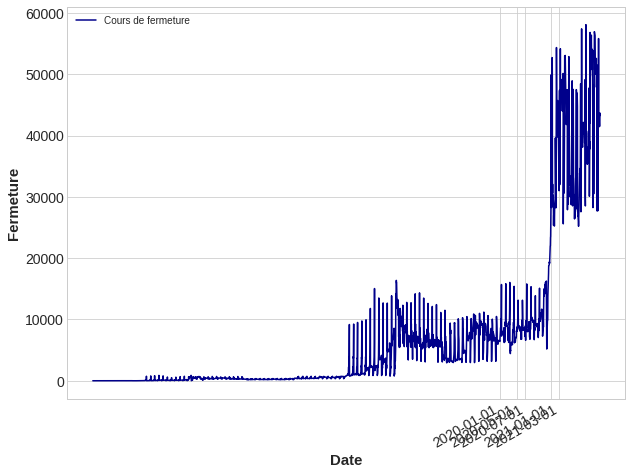

In [17]:
Close.plot(color='darkblue', label='Cours de fermeture')
plt.xticks([18262. ,18383., 18444.,  18687.,18628])
plt.ylabel('Fermeture', fontdict={'weight':'bold'})
plt.xlabel('Date',fontdict={'weight':'bold'})
plt.legend()

### Serie des log-returns

In [21]:
logrets=Close.pct_change().apply(lambda x: np.log(1 + x)).dropna()

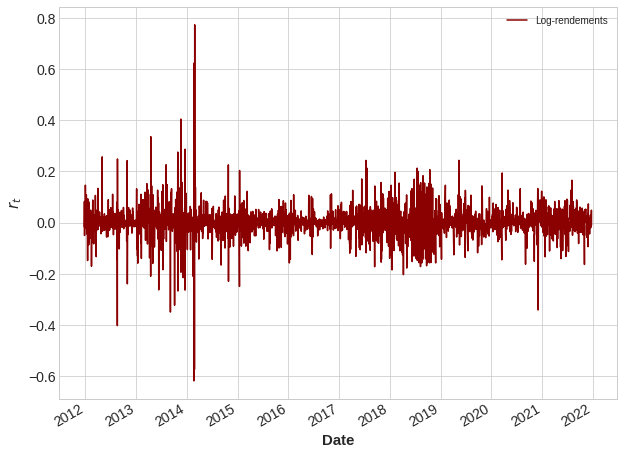

In [22]:
logrets.plot(color='darkred', label='Log-rendements')
plt.ylabel(r'$r_t$', fontdict={'weight':'bold'})
plt.xlabel('Date',fontdict={'weight':'bold'})
plt.legend()

#### Observation de la queue et de la tête des données de log-rendements

In [23]:
lrets_train = logrets.copy()
lrets_train.tail(), lrets_train.head()

(date
 2021-12-16   -0.019449
 2021-12-17   -0.019345
 2021-12-20    0.003368
 2021-12-21    0.048755
 2021-12-22   -0.009245
 Name: clot, dtype: float64,
 date
 2011-12-24   -0.016421
 2011-12-25    0.082587
 2011-12-26   -0.050010
 2011-12-27   -0.003210
 2011-12-28    0.053221
 Name: clot, dtype: float64)

### Statistiques descriptives et préliminaires à la modelisation

#### Statistiques descriptives

In [24]:
lrets_train.describe()

count    3306.000000
mean        0.002890
std         0.055802
min        -0.618224
25%        -0.013446
50%         0.002558
75%         0.021303
max         0.773201
Name: clot, dtype: float64

In [25]:
Sk = stats.skew
K = stats.kurtosis

In [26]:
Sk(lrets_train), K(lrets_train), K(lrets_train)-3

(0.32146739614713016, 29.178350410807774, 26.178350410807774)

#### Etude de la Normalité des log-returns

In [27]:
stats.shapiro(lrets_train)

ShapiroResult(statistic=0.790280282497406, pvalue=0.0)

In [28]:
stats.jarque_bera(lrets_train)

Jarque_beraResult(statistic=117334.0033278772, pvalue=0.0)

In [29]:
stats.kstest(lrets_train, 'norm')

KstestResult(statistic=0.43165969261377113, pvalue=0.0)

#### Fonction de densité empirique de la série des log-returns (KDE)

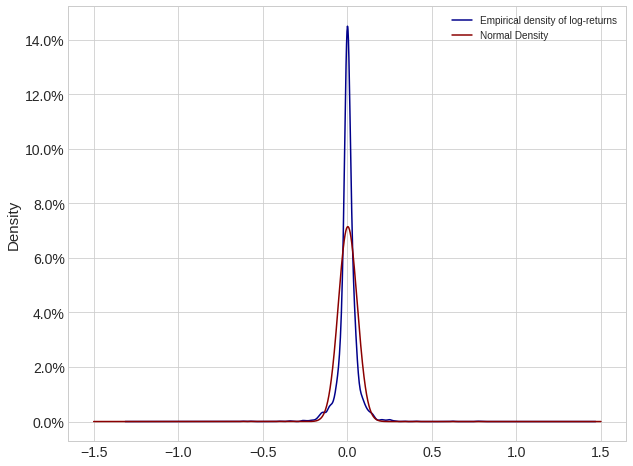

In [32]:
lrets_train.plot(kind='kde', color='darkblue', label='Empirical density of log-returns')
plt.yticks(plt.yticks()[0],[str(x)+'%' for x in plt.yticks()[0]])
x=np.linspace(-1.5, 1.5, len(lrets_train))
plt.plot(x, stats.norm.pdf(x, lrets_train.mean(), lrets_train.std()), color='darkred', label='Normal Density')
plt.legend()

#### Fonction de répartition empirique de la série de log returns

In [37]:
p = stats.norm.fit(lrets_train)

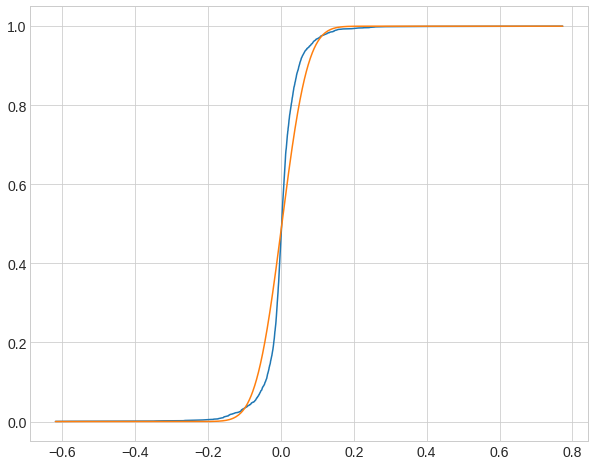

In [38]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(lrets_train)
x = ecdf.x
plt.plot(x, ecdf.y)
plt.plot(x, stats.norm.cdf(x, *p))

#### Diagrams QQ-plot of log-returns

(-4.0, 4.0)

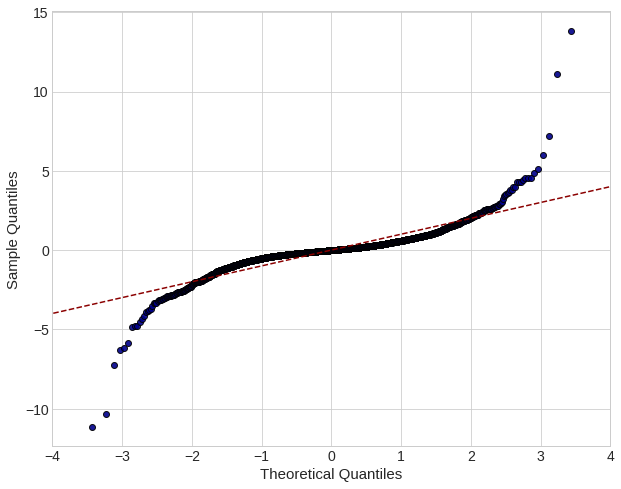

In [35]:
import statsmodels.api as sm
pp = sm.ProbPlot(lrets_train, fit=True)
qq = pp.qqplot(marker='o', markerfacecolor='darkblue', markeredgecolor='k', alpha=0.9)
sm.qqline(qq.axes[0], line='45', color='darkred', linestyle='dashed')
plt.xlim((-4,4))

#### Test des Dickey-Fuller Augmenté (ADF-Augmented Dickey-Fuller Test)

In [36]:
!pip install arch

##### Remarque : Il faut ici avoir d'abord installé le module arch avec la commande !pip install arch 

In [46]:
from arch.unitroot import ADF
trends = ['ct', 'c', 'n']
for t in trends:
    r=ADF(lrets_train, trend=t)
    print(r,'\n')

   Augmented Dickey-Fuller Results   
Test Statistic                 -9.961
P-value                         0.000
Lags                               27
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

   Augmented Dickey-Fuller Results   
Test Statistic                 -9.950
P-value                         0.000
Lags                               27
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

   Augmented Dickey-Fuller Results   
Test Statistic                 -9.620
P-value                         0.000
Lags                               27
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), 

#### Fonction d'autocorrélation partiel et Fonction d'autocorrélation (ACF /PACF )

In [ ]:
def AcfPacf(data, model=''):
    fig, ax = plt.subplots(2)
    smt.graphics.plot_acf(data, ax=ax[0], color='darkblue', vlines_kwargs={'linewidth':3,'color':'darkblue'});
    smt.graphics.plot_pacf(data, ax=ax[1], color='darkblue', vlines_kwargs={'linewidth':3,'color':'darkblue'});
    for item, itemm in zip(ax[0].collections, ax[1].collections):
        if ((type(item)==PolyCollection) & (type(itemm)==PolyCollection)) :
            item.set_facecolor('darkred')
            itemm.set_facecolor('darkred')
    ax[0].set_title('ACF' +model,fontdict={'weight':'bold'})
    ax[1].set_title('PACF' +model,fontdict={'weight':'bold'})
    return None

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


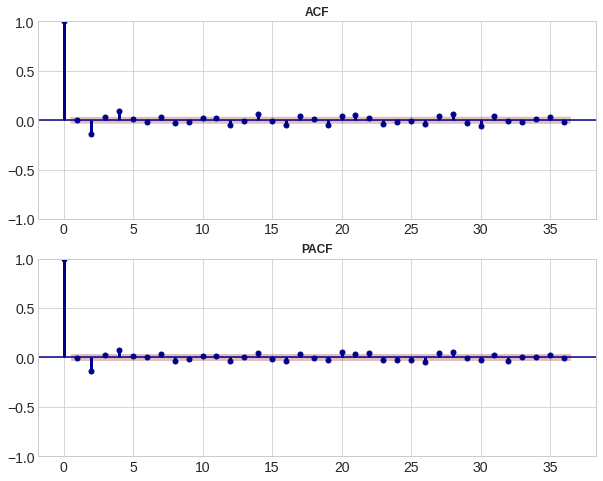

In [ ]:
AcfPacf(lrets_train)

### Lag-plots

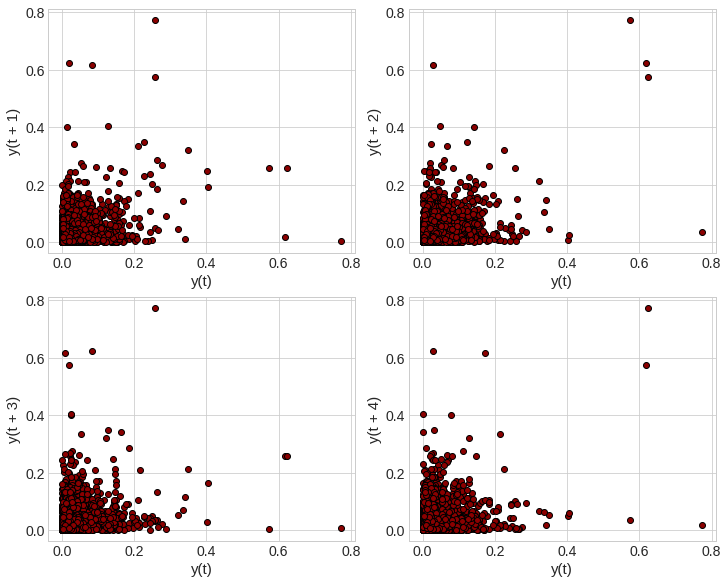

In [49]:
fig, axs = plt.subplots(2,2, constrained_layout=True)
plt.rc('axes', labelweight='bold')
plt.rcParams['patch.facecolor']='darkred'
#fig.tight_layout()
for i in range(2):
    for j in range(2):
        pd.plotting.lag_plot(np.abs(lrets_train), 2*i+j+1, ax=axs[i,j], edgecolor='black')

#save_fig('absrt_lagplots')       

** A simple illustration of volatility clustering**

789  : ( -0.0821 , -0.6182  )
------------------------------
790  : ( -0.6182 , -0.0192  )
------------------------------
791  : ( -0.0192 , 0.6239  )
------------------------------
792  : ( 0.6239 , 0.2569  )
------------------------------
793  : ( 0.2569 , -0.5735  )
------------------------------
794  : ( -0.5735 , 0.2574  )
------------------------------
795  : ( 0.2574 , 0.7732  )
------------------------------


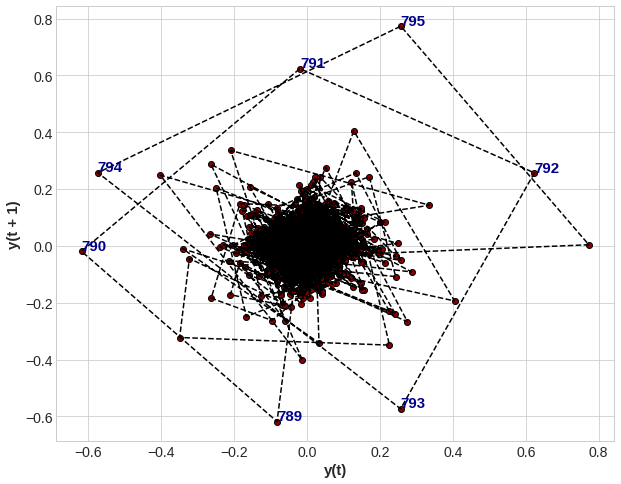

In [53]:
plt.rcParams['patch.facecolor']='darkred'
plt.plot(lrets_train.shift(1), lrets_train,'k--')
pd.plotting.lag_plot(lrets_train, 1, edgecolor='black')
for i in range(789,796):
    plt.annotate(str(i), (lrets_train.shift(1)[i], lrets_train[i]+0.004),fontweight='bold',fontsize=15, color='darkblue')
    print(str(i),' : ( %.4f' % lrets_train.shift(1)[i],', %.4f ' %lrets_train[i],')\n------------------------------')
#save_fig('Volat_Clust')    

##### Interprétation : 
Les vraiations à l'échelle logarithmique montrent que la série des log rendements est passée de -0,12 à -0,62 (Voir point 789), ensuite de -0,62 à -0,02 (Point 790), ... Le graphe traduit ainsi le fait que la volatilité varie dans le temps. Ce qui impose une nécessité de la prédire.

# Modelisation et Prevision (Forecasting)

### La prévision par lissage exponentiel (Exponential smoothing )

In [17]:
ES = smt.ExponentialSmoothing
SES = smt.SimpleExpSmoothing
holt = smt.Holt


**(1-$\alpha$) Conf-int** : 

$[$ $z_{\alpha}$ : $\alpha$ quantile of the standard normal dist, $\beta$ : smoothing parameter ($\beta = 1-\gamma$ where $\gamma$ is the smoothing param in Python)$]$

- **SES** :  $ [ \ \hat{r}_t(h) - z_{1-\frac{\alpha}{2}}\ \sigma_r C(h, \beta),\  \hat{r}_t(h) + z_{1-\frac{\alpha}{2}}\ \sigma_r C(h, \beta) \  ]$ where : $$C^2(h, \beta)= 1 + \frac{1-\beta}{(1+\beta)^3} \left[(1+4\beta + 5\beta^2) + 2h(1-\beta)(1+3\beta) + 2h^2(1-\beta)^2 \right] $$

In [54]:
import warnings
warnings.filterwarnings('ignore')

class ExpSmooth:
    def __init__(self, data):
        self.data = data
        return None

    def __C(self, h, beta):
        return 1+ ((1-beta)/(1+beta**3))*(1+4*beta+5*beta**2 + 2*h*(1-beta)*(1+3*beta) + 2*(h**2)*(1-beta)**2)

    def __ConfInt(self, forecasts, beta,  method, horizon, alpha=.05):
        idx = forecasts.index[0]
        ci = []
        sigma = self.data.std()
        z = stats.norm.ppf(1-alpha/2)
        for h in range(horizon):
            if (method== 'SES'):
                ci.append([forecasts[idx + h]-z*sigma*np.sqrt(self.__C(h, beta)),forecasts[idx + h]+z*sigma*np.sqrt(self.__C(h, beta))])
            if (method == 'Holt'):
                ci.append([forecasts[idx + h]-z*sigma*np.sqrt((2*beta)/(2*beta-1)),forecasts[idx + h]+z*sigma*np.sqrt((2*beta)/(2*beta-1))]) 

        return pd.DataFrame(ci, columns=['down', 'up'])

    def SES(self, forecasts_horizon=1):
        ses_fit = SES(self.data, initialization_method='estimated').fit()
        ses_forecasts = ses_fit.forecast(forecasts_horizon).rename(r'$\beta = %s$'%np.round(1 - ses_fit.params['smoothing_level'], 3))
        beta = 1-ses_fit.params['smoothing_level']
        return ses_fit, ses_forecasts, self.__ConfInt(ses_forecasts, beta= beta, method='SES', horizon=forecasts_horizon)

    def HoltMethod(self, forecasts_horizon=1):
        holt_fit = holt(self.data, initialization_method='estimated').fit()
        beta = 1 - np.sqrt(1 - holt_fit.params['smoothing_level'])
        beta  = np.sqrt(1-beta)
        holt_forecasts = holt_fit.forecast(forecasts_horizon).rename(r'$\beta = %s$'%np.round(beta, 4))
        return holt_fit, holt_forecasts, self.__ConfInt(ses_forecasts, beta= beta, method='Holt',horizon=forecasts_horizon)

In [55]:
es = ExpSmooth(lrets_train)

### SES : 

In [56]:
ses_fit, ses_forecasts, ses_ci = es.SES(forecasts_horizon=len(lrets_train))

NameError: name 'lrets_valid' is not defined

Saving figure SES 




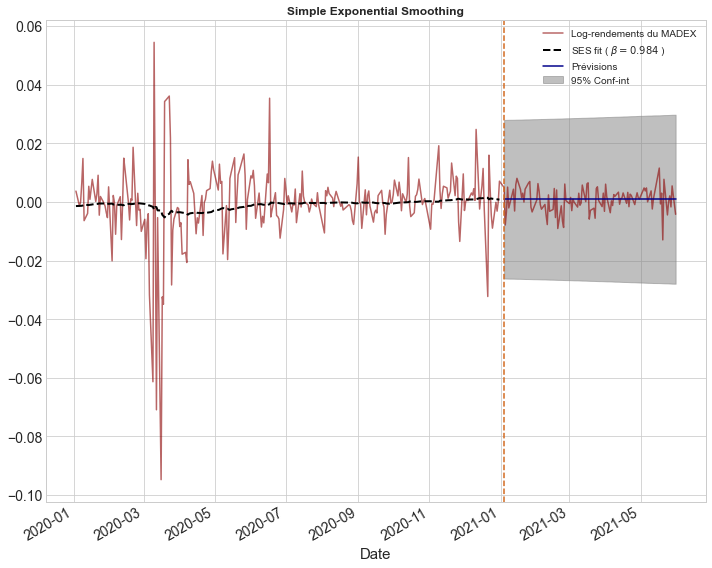

In [45]:
logrets.plot(color='darkred', alpha=0.6)
plt.plot(ses_fit.fittedvalues, color='black', linestyle='dashed', linewidth=2)
plt.plot(lrets_valid.index, ses_forecasts, color='darkblue')
plt.fill_between(lrets_valid.index, ses_ci['down'],ses_ci['up'], color='gray', alpha=0.5)
plt.title('Simple Exponential Smoothing', fontdict={'weight':'bold'})
plt.legend(['Log-rendements du MADEX','SES fit ( '+ ses_forecasts.name +' )', 'Prévisions','95% Conf-int'])
plt.axvline(x=lrets_valid.index[0], linestyle='dashed', color='chocolate')
#save_fig('SES')

In [12]:
def RMSE(data1, data2):
    n = len(data1)
    print('RMSE : ')
    return np.sqrt(((data2-data1)**2).sum()/n)

In [53]:
# Prediction Error : RMSE
RMSE(ses_forecasts, lrets_test.values)

RMSE : 


0.004185295333452249

### Holt

In [47]:
holt_fit, holt_forecasts, holt_ci = es.HoltMethod(forecasts_horizon=len(lrets_valid))

Saving figure Holt 




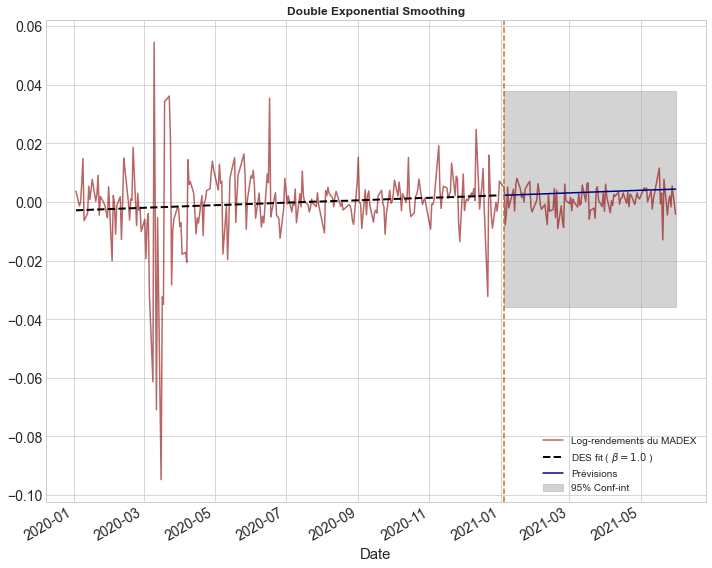

In [49]:
logrets.plot(color='darkred', alpha=0.6)
plt.plot(holt_fit.fittedvalues, color='black', linestyle='dashed', linewidth=2)
plt.plot(lrets_valid.index, holt_forecasts, color='darkblue')
plt.fill_between(lrets_valid.index, holt_ci['down'], holt_ci['up'], color='darkgray', alpha=0.5)
plt.title('Double Exponential Smoothing', fontdict={'weight':'bold'})
plt.legend(loc= 'lower right', labels=['Log-rendements du MADEX','DES fit ( '+ holt_forecasts.name +' )', 'Prévisions','95% Conf-int'])
plt.axvline(x=lrets_valid.index[0], linestyle='dashed', color='chocolate')
#save_fig('Holt')

In [54]:
RMSE(holt_forecasts, lrets_test.values)

RMSE : 


0.004959140771576316

## Holt-Winters (non-seasonal)

In [341]:
hw = ES(lrets_train, trend = 'add', seasonal=None, initialization_method='estimated').fit()
hw_cast = hw.forecast(len(lrets_valid))

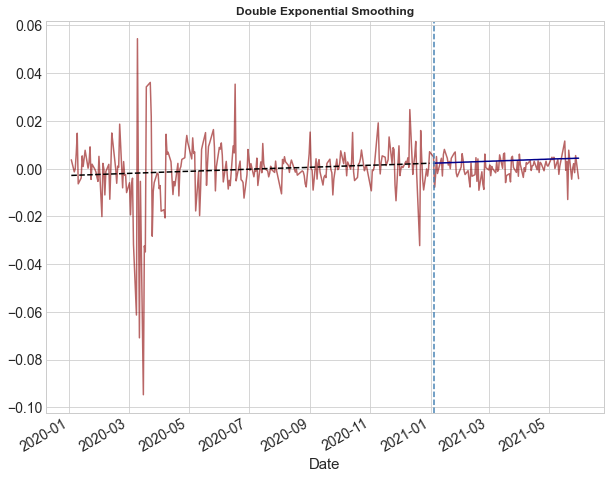

In [343]:
# The same as Holt
logrets.plot(color='darkred', alpha=0.6)
plt.plot(hw.fittedvalues, color='black',linestyle='dashed')
plt.plot(lrets_valid.index, hw_cast, color='darkblue')
plt.title('Double Exponential Smoothing', fontdict={'weight':'bold'})
plt.axvline(x=lrets_valid.index[0], linestyle='dashed', color='steelblue')

## Ljung-Box test

In [15]:
lj = sm.stats.diagnostic.acorr_ljungbox(lrets_train, auto_lag=True,return_df=True)
print(lj)

     lb_stat  lb_pvalue
1   9.055162   0.002620
2  12.156962   0.002292
3  12.504289   0.005841
4  17.167393   0.001793
5  18.003246   0.002942
6  18.009263   0.006209
7  24.417000   0.000962


# ARIMA Model:

Saving figure ARIMA(1,0,1) 


model : ARIMA ( 1 ,0, 1 ) AIC :  -1448.6115 p-value :  0.0112
Saving figure ARIMA(1,0,2) 


model : ARIMA ( 1 ,0, 2 ) AIC :  -1447.6899 p-value :  0.0075
Saving figure ARIMA(2,0,1) 


model : ARIMA ( 2 ,0, 1 ) AIC :  -1447.0775 p-value :  0.0059
Saving figure ARIMA(2,0,2) 


model : ARIMA ( 2 ,0, 2 ) AIC :  -1455.6938 p-value :  0.2377


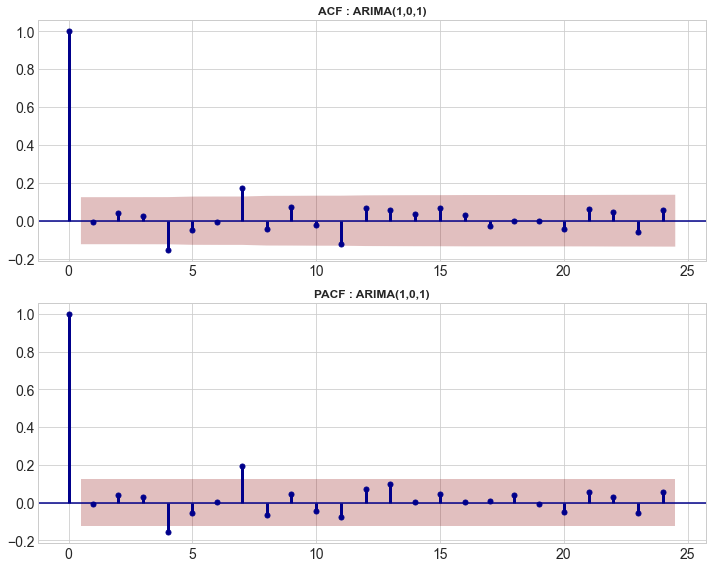

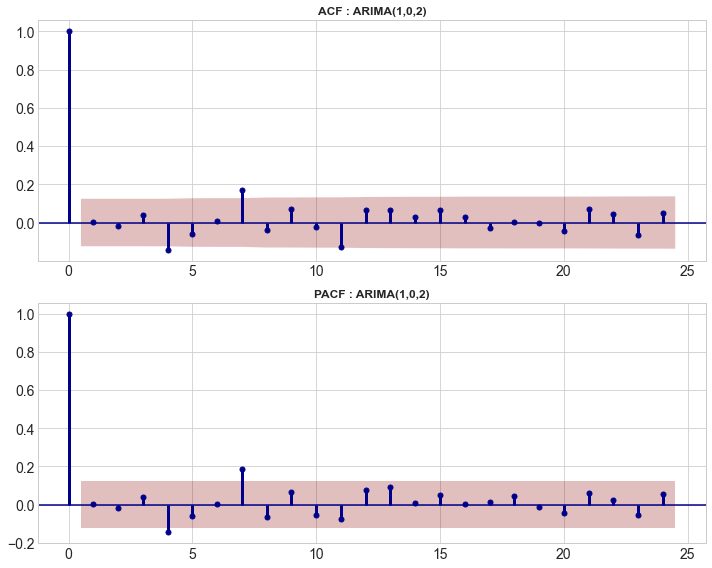

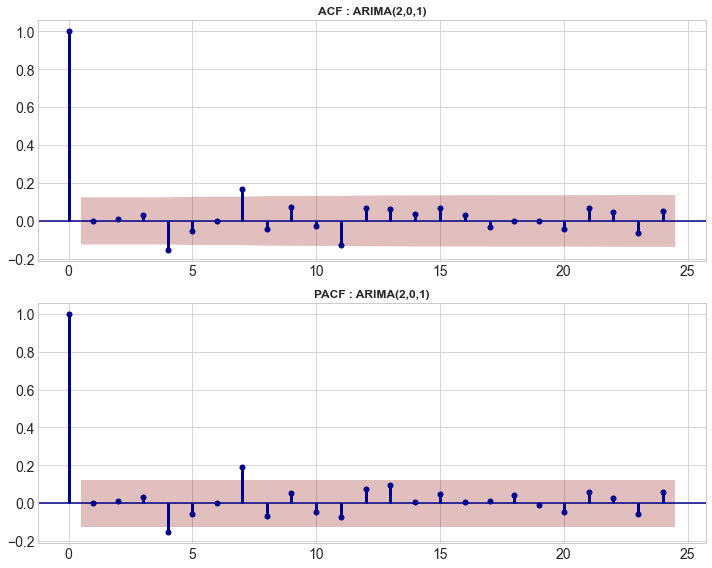

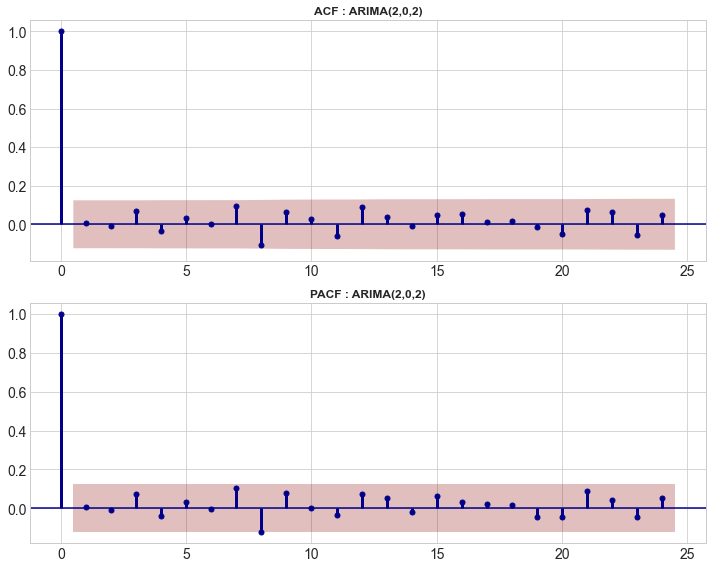

In [24]:
for p in range(1,3):
    for q in range(1,3):
            mdl=smt.ARIMA(lrets_train, order=(p,0,q)).fit  (trend="c")
            res=mdl.resid
            lj=sm.stats.diagnostic.acorr_ljungbox(res,lags=[7], model_df=p+q,return_df=True)
            pv=lj.values[0][1]
            AcfPacf(res, model=' : ARIMA(' + str(p)+',0,'+str(q)+')')
            #save_fig('ARIMA(' + str(p)+',0,'+str(q)+')')
            print('model : ARIMA (',p,',0,',q,')', 'AIC : ',np.round(mdl.aic,4),'p-value : ',np.round(pv, 4))

In [13]:
import pmdarima as pmd

In [14]:
#x=pmd.auto_arima(lrets_train, with_intercept=True, trend="c")
mean_mdl=pmd.auto_arima(lrets_train)

In [18]:
mean_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  249
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 733.806
Date:                Mon, 21 Jun 2021   AIC                          -1457.611
Time:                        13:59:37   BIC                          -1440.024
Sample:                             0   HQIC                         -1450.532
                                - 249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9991      0.115      8.698      0.000       0.774       1.224
ar.L2         -0.7935      0.082     -9.718      0.000      -0.954      -0.633
ma.L1         -0.8501      0.104     -8.212      0.000      -1.053      -0.647
ma.L2          0.7958      0.083      9.640      0.000       0.634       0.958
sigma2         0.0002   5.79e-06     27.829      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2996.05
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -1.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Checking if the ARMA representation is minimal

In [64]:
print('AR roots : ', mean_mdl.arroots() ,'\n\nMA roots : ', mean_mdl.maroots())

AR roots :  [0.62951836-0.92946248j 0.62951836+0.92946248j] 

MA roots :  [0.53409531-0.98557502j 0.53409531+0.98557502j]


In [18]:
residuals = pd.Series(mean_mdl.resid(), index=lrets_train.index)

### Residuals analysis

In [101]:
#stats.shapiro(residuals)
stats.kstest(residuals, 'norm')

KstestResult(statistic=0.48229592475762917, pvalue=8.062751837234154e-54)

Saving figure Resid_dens 




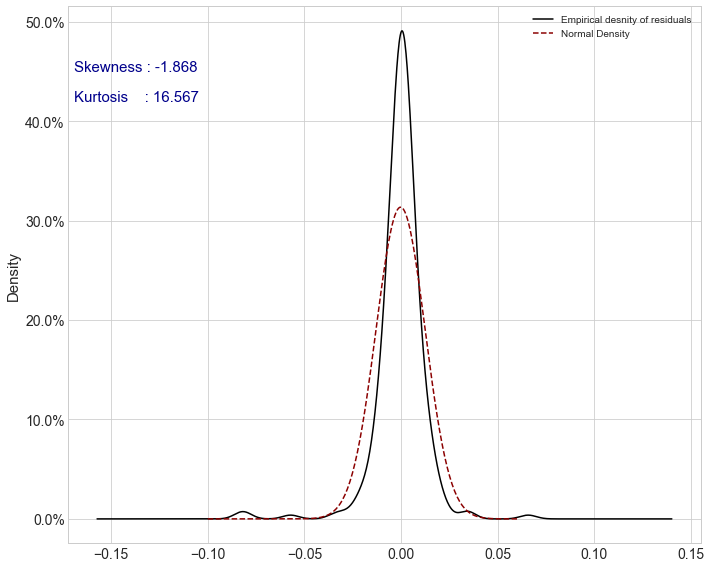

In [104]:
residuals.plot(kind='kde', color='black',label='Empirical desnity of residuals')
plt.yticks(plt.yticks()[0],[str(x)+'%' for x in plt.yticks()[0]])
x=np.linspace(-0.1, 0.06, len(lrets_train))
plt.plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), color='darkred',linestyle='dashed', label='Normal Density')
plt.legend()
plt.annotate('Skewness : ' + str(np.round(Sk(residuals),3)), (-0.169, 45),fontsize=15, color='darkblue')
plt.annotate('Kurtosis    : ' + str(np.round(K(residuals),3)), (-0.169, 42),fontsize=15, color='darkblue')
save_fig('Resid_dens')

In [232]:
p = stats.t.fit(residuals)
stats.kstest(residuals, 't', args=p)

KstestResult(statistic=0.027439347029434513, pvalue=0.9894807176773781)

Saving figure Resid_dens 




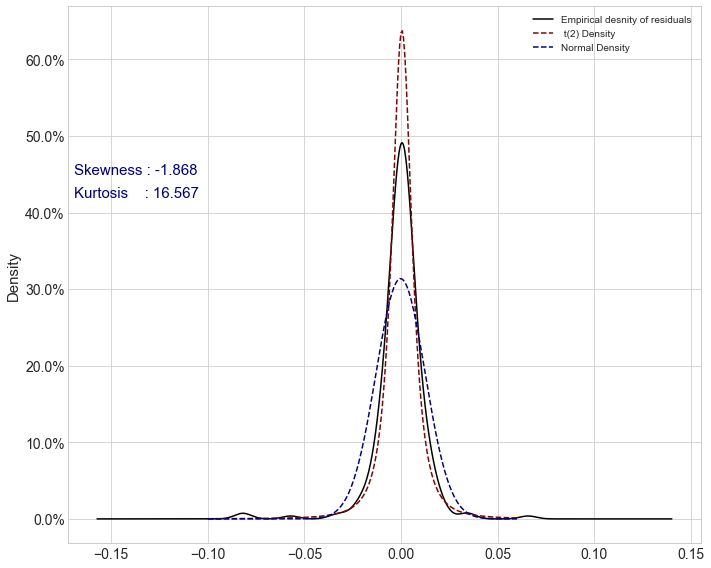

In [120]:
residuals.plot(kind='kde', color='black',label='Empirical desnity of residuals')
plt.yticks(plt.yticks()[0],[str(x)+'%' for x in plt.yticks()[0]])
x=np.linspace(-0.1, 0.06, len(lrets_train))
plt.plot(x, stats.t.pdf(x, *p), color='darkred',linestyle='dashed', label=' t(2) Density')
plt.plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), color='darkblue',linestyle='dashed', label='Normal Density')
plt.legend()
plt.annotate('Skewness : ' + str(np.round(Sk(residuals),3)), (-0.169, 45),fontsize=15, color='darkblue')
plt.annotate('Kurtosis    : ' + str(np.round(K(residuals),3)), (-0.169, 42),fontsize=15, color='darkblue')
#save_fig('Resid_dens')

Saving figure res_squared 




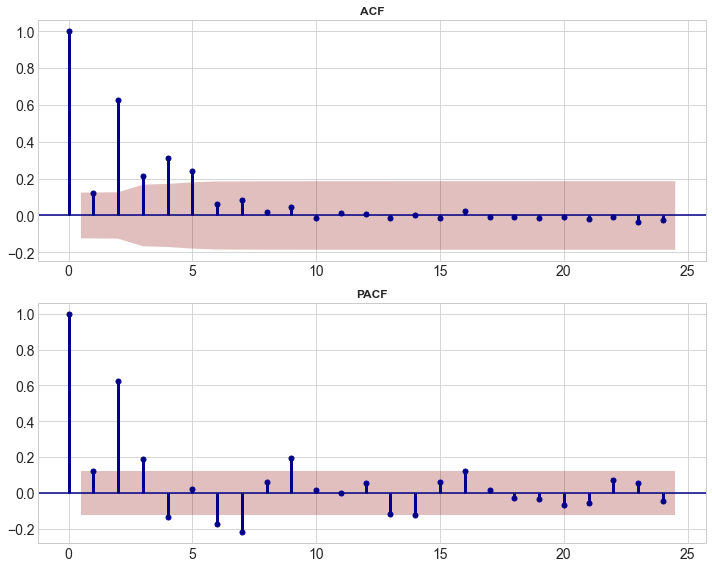

In [122]:
AcfPacf(residuals**2)
#save_fig('res_squared')

Saving figure Res 




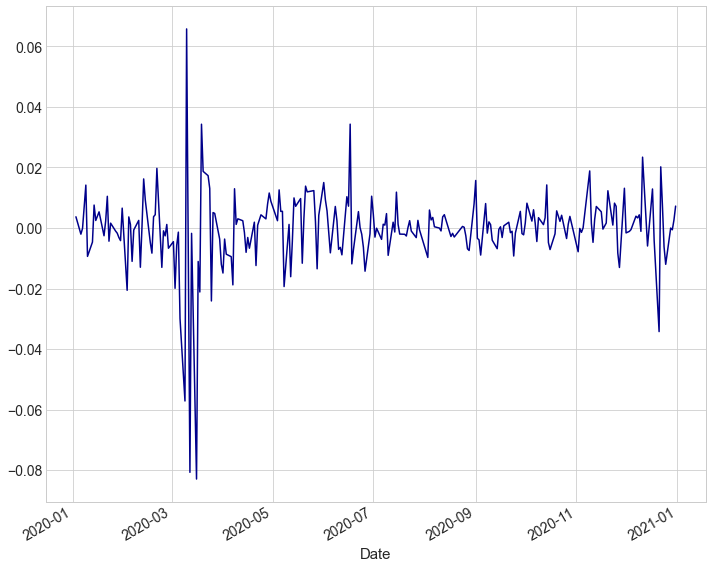

In [130]:
residuals.plot(color='darkblue')
save_fig('Res')

### Estimating Volatility

In [15]:
class VolatilityEst:
    __Estimators__ = ['Rolling', 'EWMA', 'RogersSatchell', 'Parkinson', 'GarmanKlass']

    def __init__(self, data):
        self.data = data
        return None
    def printNames(self):
        return VolatilityEst.__Estimators__    

    def __getLret(self, close):
        return close.pct_change().apply(lambda x: np.log(1 + x)).dropna()

    def Estimate(self, window = 5, name = 'Rolling'):
        if (name == 'Rolling'):
            est = np.sqrt((self.__getLret(self.data['Close'])**2).rolling(window).mean())

        if(name == 'EWMA'):
            est = np.sqrt((self.__getLret(self.data['Close'])**2).ewm(alpha=1.-0.94).mean())
             

        if(name == 'RogersSatchell'):
            est = np.sqrt( (np.log(self.data['High']/self.data['Low']) * np.log(self.data['High']/self.data['Close']) + np.log(self.data['Low']/self.data['Open']) * np.log(self.data['Low']/self.data['Close'])).rolling(window).mean())

        if(name == 'Parkinson'):
            est = np.sqrt(((0.25/np.log(2))*(np.log(self.data['High']/self.data['Low']))**2).rolling(window).mean())

        if(name == 'GarmanKlass'):
            c = window/(window-1)
            est = np.sqrt((0.51*c*(np.log(self.data['High']/self.data['Low']))**2 - 0.39*c*self.__getLret(self.data['Close'])**2).rolling(window).mean())

        return est[:'2020-12-31']

In [141]:
vol = VolatilityEst(MADEX)

In [120]:
vol.printNames()

['Rolling', 'EWMA', 'RogersSatchell', 'Parkinson', 'GarmanKlass']

Saving figure Volat_est 




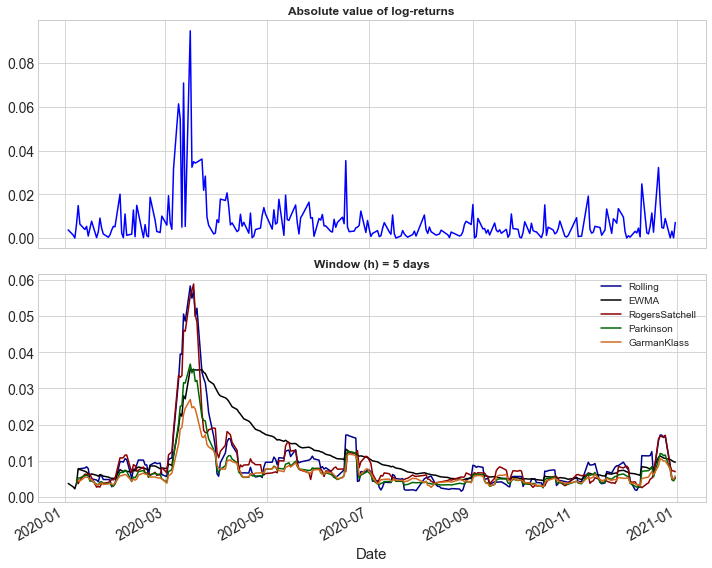

In [164]:
colors = ['darkblue', 'black', 'darkred', 'darkgreen', 'chocolate']
fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True)
lrets_train.apply(lambda x: np.abs(x)).plot(color='blue', ax=axs[0])
axs[0].set_title('Absolute value of log-returns', fontdict={'weight':'bold'})
for name, color in zip(vol.printNames(), colors):
    vol.Estimate(name=name).plot(label=name, color=color, ax=axs[1])
plt.title('Window (h) = 5 days', fontdict={'weight':'bold'})
plt.legend()
#save_fig('Volat_est')

Saving figure IC 


Saving figure IC 


Saving figure IC 


Saving figure IC 




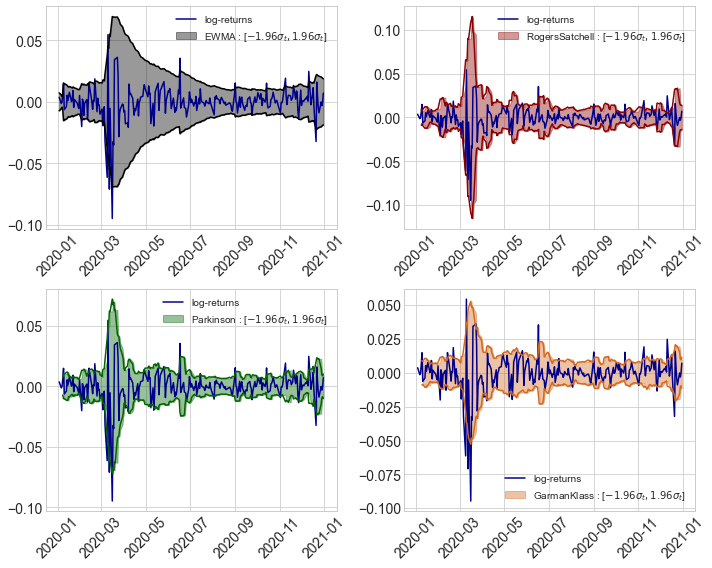

In [224]:
fig, axs = plt.subplots(2,2, constrained_layout=True)
for name, color, ax in zip(vol.printNames()[1:], colors[1:], axs.flat):
    est = 1.96*vol.Estimate(name=name)
    ax.plot(lrets_train, color='darkblue', label='log-returns')
    ax.plot(est, color=color)
    ax.plot(-est, color=color)
    ax.fill_between(lrets_train.index, -est[0:len(lrets_train.index)], est[0:len(lrets_train.index)],label=name + r' : [$-1.96\sigma_t,1.96\sigma_t$]' ,color=color ,alpha=0.4)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=45 )
    ax.legend()
    #save_fig('IC')

In [225]:
stats.norm.ppf(0.975)

1.959963984540054

# GARCH Model

### Testing for ARCH effects

In [16]:
from statsmodels.stats.diagnostic import het_arch

In [19]:
test_arch=het_arch(residuals, nlags=2)
name=["LM","LM p-value", "F", "F p-value"]
res_arch=pd.Series(test_arch, index=name)
res_arch

LM            9.731810e+01
LM p-value    7.372962e-22
F             7.932027e+01
F p-value     2.894830e-27
dtype: float64

### Garch model for residuals

In [20]:
from arch.univariate import arch_model
var_model=arch_model(residuals, mean = 'Zero', vol="GARCH", rescale=True, dist='StudentsT').fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 540.9565364835546
Iteration:      2,   Func. Count:     16,   Neg. LLF: 357.533364854205
Iteration:      3,   Func. Count:     23,   Neg. LLF: 577.3041903496503
Iteration:      4,   Func. Count:     29,   Neg. LLF: 528.2850836478981
Iteration:      5,   Func. Count:     35,   Neg. LLF: 517.2867983372147
Iteration:      6,   Func. Count:     41,   Neg. LLF: 504.49425866000263
Iteration:      7,   Func. Count:     47,   Neg. LLF: 336.1640210498693
Iteration:      8,   Func. Count:     53,   Neg. LLF: 316.0812054519607
Iteration:      9,   Func. Count:     59,   Neg. LLF: 314.35680483982804
Iteration:     10,   Func. Count:     64,   Neg. LLF: 314.2610727535479
Iteration:     11,   Func. Count:     69,   Neg. LLF: 314.3943841351694
Iteration:     12,   Func. Count:     75,   Neg. LLF: 314.11049717950476
Iteration:     13,   Func. Count:     80,   Neg. LLF: 314.06233562045713
Iteration:     14,   Func. Count:     85,   Neg. LLF: 314.048

In [27]:
var_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Zero Mean - GARCH Model Results                           
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.004
Vol Model:                            GARCH   Log-Likelihood:               -314.044
Distribution:      Standardized Student's t   AIC:                           636.088
Method:                  Maximum Likelihood   BIC:                           650.158
                                              No. Observations:                  249
Date:                      Tue, Jun 22 2021   Df Residuals:                      249
Time:                              16:49:11   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0917  5.458e-02      1.680  9.289e-02 [-1.526e-02,  0.199]
alpha[1]       0.2657      0.134      1.978  4.797e-02  [2.380e-03,  0.529]
beta[1]        0.7253  8.514e-02      8.519  1.614e-17    [  0.558,  0.892]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.1681      0.671      4.720  2.359e-06 [  1.853,  4.484]
========================================================================

Covariance estimator: robust
"""

In [33]:
p =model.params
uncv=(p[0]/100 )/ (1-(p[1]+p[2])/100)
print('Unconditional Variance : ', uncv)

Unconditional Variance :  0.0009263038185050727


### Variance model residuals checking

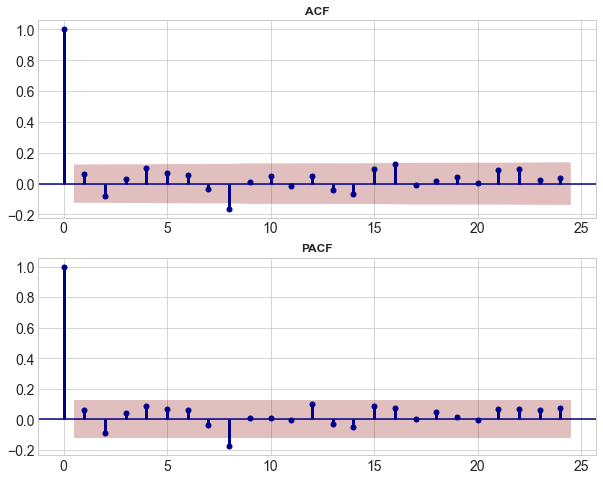

In [29]:
eta = var_model.resid/var_model.conditional_volatility
AcfPacf(eta)
#save_fig('res')

In [31]:
lj = sm.stats.diagnostic.acorr_ljungbox(eta, lags=7, return_df=True)
lj

lb_stat  lb_pvalue
1  0.928382   0.335284
2  2.682071   0.261575
3  2.923457   0.403578
4  5.444749   0.244629
5  6.776300   0.237816
6  7.543489   0.273491
7  7.827084   0.348088

In [30]:
test_arch=het_arch(eta)
name=["LM","LM p-value", "F", "F p-value"]
res_arch=pd.Series(test_arch, index=name)
res_arch

LM            7.444435
LM p-value    0.963714
F             0.445566
F p-value     0.968373
dtype: float64

## Forecasts

** rugarch (R package) to the rescue!**

In [143]:
from rpy2.robjects.packages import importr, data
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import FloatVector
import rpy2.robjects.numpy2ri as rpyn
rugarch = importr('rugarch')
base = importr('base')

In [35]:
arch_spec = rugarch.ugarchspec(mean_model = ro.r('list(armaOrder=c(2,2), include.mean=F)'), variance_model = ro.r('list(model="sGARCH", garchOrder=c(1,1), include.mean=F)'), distribution_model='std')
train = FloatVector(lrets_train.values)
arch_fit = rugarch.ugarchfit(spec=arch_spec, data=train)
arch_forecast = rugarch.ugarchforecast(arch_fit, n_ahead = len(lrets_test))

In [40]:
ro.r(""" test <- function(s) {retour = cbind(attr(s, 'forecast')$seriesFor,attr(s, 'forecast')$sigmaFor)
return(retour)}""")

ro.r(""" fits <- function(s) {return(attr(s, 'fit')$fitted.values)}""")
returnFit = ro.globalenv['fits']
returnForc = ro.globalenv['test']

x = returnForc(arch_forecast)
rsortie=pd.DataFrame(np.array(x).reshape(103,2), index=lrets_test.index, columns=['forecasts', 'volFor'])
rsortie['down'] = rsortie['forecasts']-(stats.t.ppf(0.975, df=3)/3)*np.sqrt(uncv)*rsortie['volFor']
rsortie['up'] = rsortie['forecasts']+(stats.t.ppf(0.975, df=3)/3)*np.sqrt(uncv)*rsortie['volFor']

fits = pd.Series(np.array(returnFit(arch_fit)), index=lrets_train.index)

In [42]:
RMSE(lrets_test, rsortie['forecasts'].values)

RMSE : 


0.00424652120090644

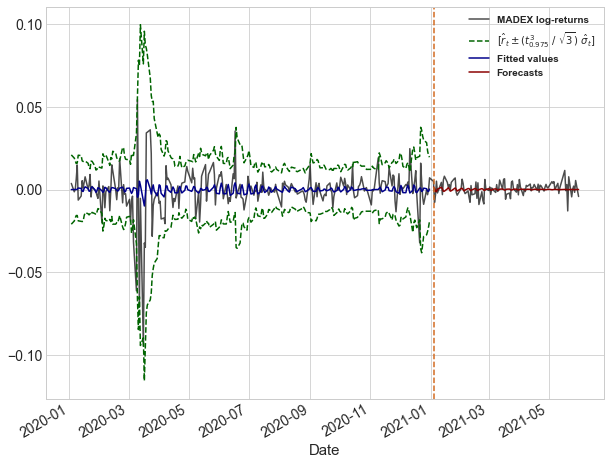

In [43]:
logrets.plot(color='black', alpha=0.7, label='MADEX log-returns')
(fits+(stats.t.ppf(0.975, df=3)/np.sqrt(3))*var_model.conditional_volatility/100).plot(color='darkgreen', linestyle='dashed', label=r'$[\hat{r}_t\pm(t_{0.975}^3 \ / \ \sqrt{3})\ \hat{\sigma}_t]$')
(fits-(stats.t.ppf(0.975, df=3)/np.sqrt(3))*var_model.conditional_volatility/100).plot(color='darkgreen', linestyle='dashed', label='')
fits.plot(color='darkblue', label='Fitted values')
rsortie['forecasts'].plot(color='darkred', label='Forecasts')
plt.axvline(lrets_test.index[0], color='chocolate', linestyle='dashed')
plt.legend(prop={'weight':'bold'})
#save_fig('fits_forecasts')

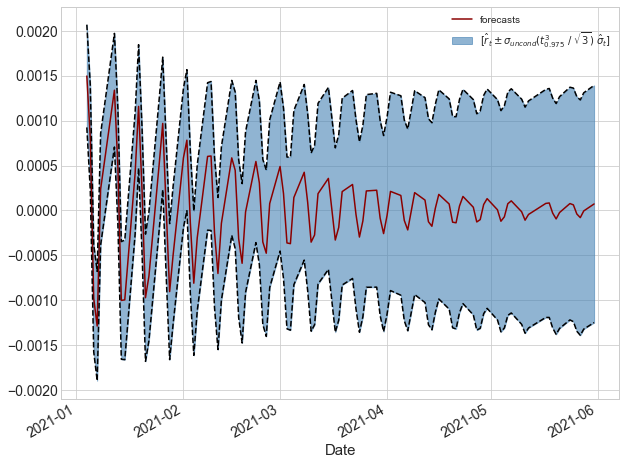

In [44]:
rsortie['forecasts'].plot(color='darkred', label='forecasts')
(rsortie['forecasts']+(stats.t.ppf(0.975, df=3)/np.sqrt(3))*np.sqrt(uncv)*rsortie['volFor']).plot(color='black',linestyle='dashed', label='')
(rsortie['forecasts']-(stats.t.ppf(0.975, df=3)/np.sqrt(3))*np.sqrt(uncv)*rsortie['volFor']).plot(color='black', linestyle='dashed', label='')
plt.fill_between(lrets_test.index,rsortie['forecasts']-(stats.t.ppf(0.975, df=3)/np.sqrt(3))*np.sqrt(uncv)*rsortie['volFor'], rsortie['forecasts']+(stats.t.ppf(0.975, df=3)/np.sqrt(3))*np.sqrt(uncv)*rsortie['volFor'],label=r'$[\hat{r}_t \pm \sigma_{uncond} (t_{0.975}^3 \ / \ \sqrt{3})\ \hat{\sigma}_t]$', color='steelblue', alpha=0.6)
plt.legend()
#save_fig('Zoom_forecats')

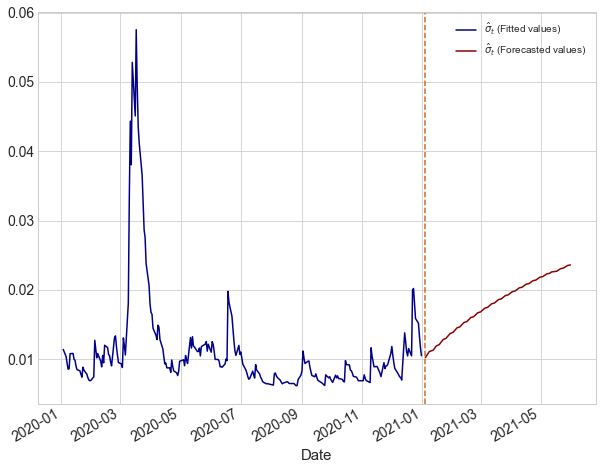

In [45]:
(var_model.conditional_volatility/100).plot(color='darkblue', label=r'$\hat{\sigma}_t$' + ' (Fitted values)')
rsortie['volFor'].plot(color='darkred',label=r'$\hat{\sigma}_t$' + ' (Forecasted values)')
plt.axvline(lrets_test.index[0], color='chocolate', linestyle='dashed')
plt.legend()
#save_fig('vol_GARCH')

In [46]:
ARIMA_Forecast=pd.Series(mean_mdl.predict(n_periods=len(lrets_valid)), index=lrets_test.index)

Saving figure ARIMA_vs_GARCH 




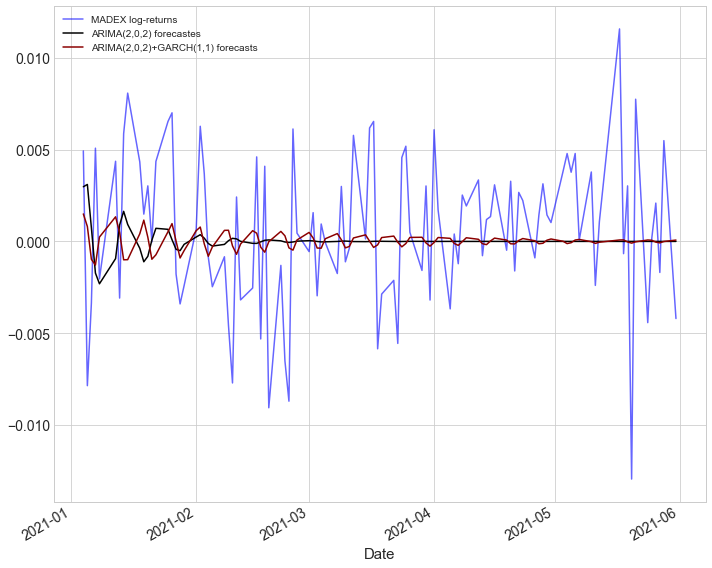

In [274]:
lrets_test.plot(color='blue',label='MADEX log-returns', alpha=0.6)
ARIMA_Forecast.plot(color='black', label='ARIMA(2,0,2) forecastes')
rsortie['forecasts'].plot(color='darkred', label='ARIMA(2,0,2)+GARCH(1,1) forecasts')
plt.legend()
#save_fig('ARIMA_vs_GARCH')

In [277]:
rmse_arima=RMSE(ARIMA_Forecast.values, lrets_test.values)
rmse_arimagarch = RMSE(rsortie['forecasts'].values, lrets_test.values)
print('ARIMA(2,0,2) RMSE : %.8f' % rmse_arima)
print('ARIMA(2,0,2)+GARCH(1,1) RMSE : %.8f' % rmse_arimagarch)

RMSE : 
RMSE : 
ARIMA(2,0,2) RMSE : 0.00426881
ARIMA(2,0,2)+GARCH(1,1) RMSE : 0.00424652


# VaR

In [70]:
log_returns = pd.read_csv('MADEX_lrets.csv', parse_dates=[0], index_col=0).squeeze()

In [73]:
log_returns.head

<bound method NDFrame.head of Date
2016-06-21    0.003762
2016-06-22   -0.009141
2016-06-23    0.003798
2016-06-24    0.003638
2016-06-27   -0.012249
                ...   
2021-06-15   -0.005487
2021-06-16   -0.004111
2021-06-17   -0.001006
2021-06-18    0.003807
2021-06-21    0.004941
Name: Close, Length: 1241, dtype: float64>

Saving figure Var_rets 




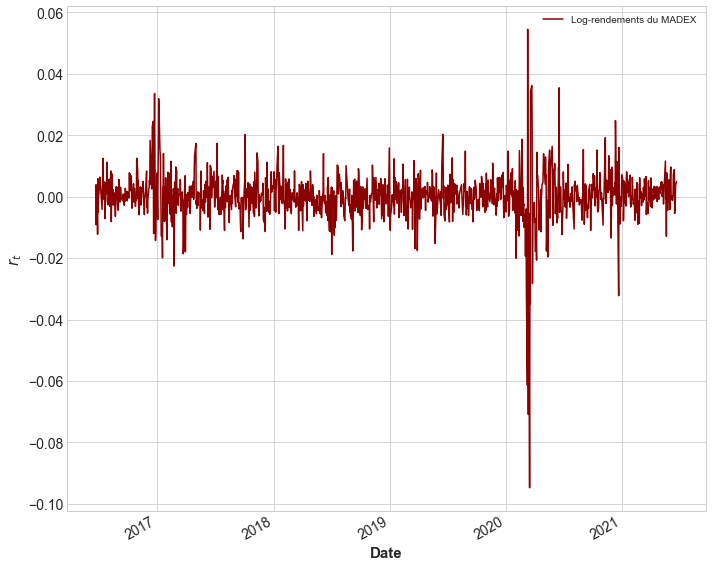

In [72]:
log_returns.plot(color='darkred', label='Log-rendements du MADEX')
plt.ylabel(r'$r_t$', fontdict={'weight':'bold'})
plt.xlabel('Date',fontdict={'weight':'bold'})
plt.legend()
#save_fig('Var_rets')

In [74]:
Var_res = pmd.auto_arima(log_returns)

Saving figure Var_ACF_PACF 




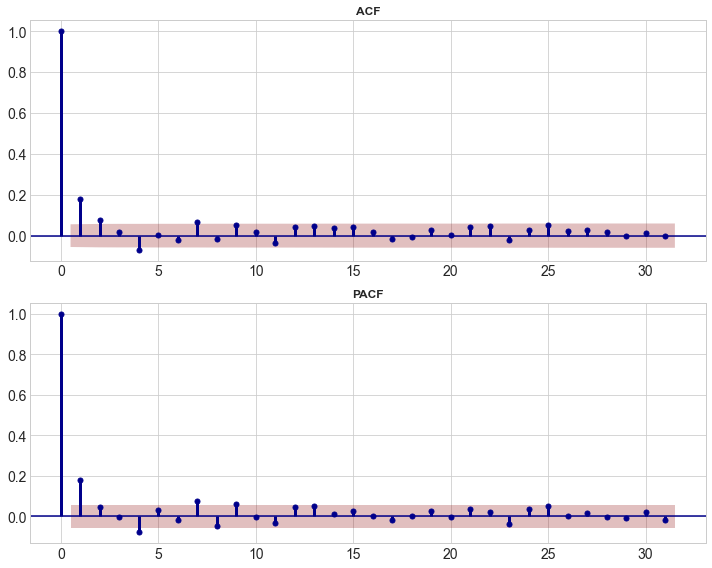

In [111]:
AcfPacf(log_returns)
save_fig('Var_ACF_PACF')

In [144]:
Var_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1241
Model:               SARIMAX(2, 0, 0)   Log Likelihood                4266.114
Date:                Wed, 23 Jun 2021   AIC                          -8526.228
Time:                        19:49:36   BIC                          -8510.857
Sample:                             0   HQIC                         -8520.448
                               - 1241                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1713      0.011     15.333      0.000       0.149       0.193
ar.L2          0.0467      0.008      6.163      0.000       0.032       0.062
sigma2      6.047e-05   6.45e-07     93.709      0.000    5.92e-05    6.17e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             42582.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
residus=pd.Series(Var_res.resid(), index=log_returns.index)

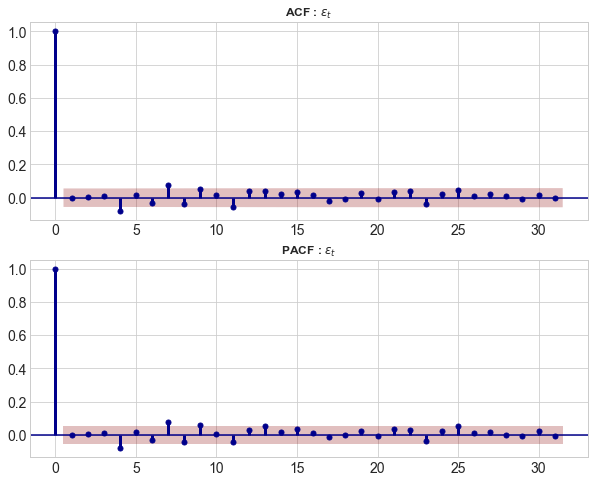

In [96]:
AcfPacf(residus, ' : ' + r'$\varepsilon_t$')

In [145]:
lj = sm.stats.diagnostic.acorr_ljungbox(residus, lags=7, return_df=True)
lj

lb_stat  lb_pvalue
1   0.000895   0.976140
2   0.016389   0.991839
3   0.146474   0.985729
4   8.258474   0.082556
5   8.579726   0.127048
6   9.742240   0.135935
7  16.784816   0.018838

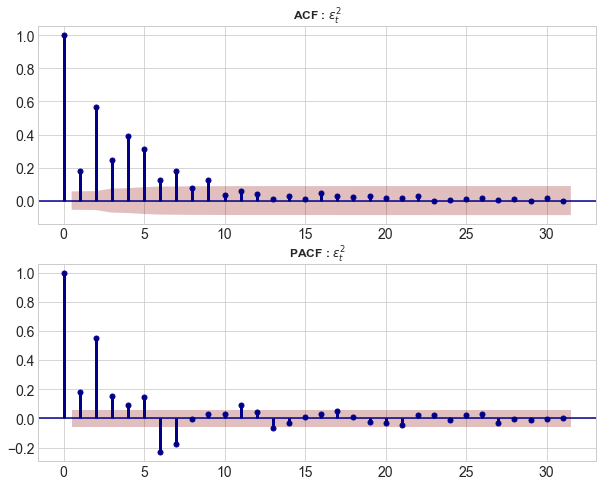

In [94]:
AcfPacf(residus**2, ' : ' + r'$\varepsilon_t^2$')

In [88]:
test_arch=het_arch(residus)
name=["LM","LM p-value", "F", "F p-value"]
res_arch=pd.Series(test_arch, index=name)
res_arch

LM             5.242148e+02
LM p-value     3.194436e-96
F              3.922480e+01
F p-value     2.298847e-128
dtype: float64

In [114]:
p = stats.t.fit(residus)
p1=stats.norm.fit(residus)
stats.kstest(residus, 't', args=p), stats.kstest(residus, 'norm', args=p1)


(KstestResult(statistic=0.014143927644839738, pvalue=0.962069407890592),
 KstestResult(statistic=0.0999984567165268, pvalue=2.957958171363219e-11))

In [90]:
variance_model=arch_model(residus, mean = 'Zero', vol="GARCH", rescale=True, dist='StudentsT').fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 21963.511415080357
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2394.6773599987723
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2430.5640945396417
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2208.9643013735213
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1125.0031805066749
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1090.1107381076395
Iteration:      7,   Func. Count:     43,   Neg. LLF: 1090.1279463016824
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1090.0891858481905
Iteration:      9,   Func. Count:     54,   Neg. LLF: 1090.0840171345967
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1090.0840039885497
Iteration:     11,   Func. Count:     63,   Neg. LLF: 1090.084003988547
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1090.0840039885497
            Iterations: 11
            Function evaluations: 63
            Gradient eval

In [119]:
variance_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Zero Mean - GARCH Model Results                           
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -1090.08
Distribution:      Standardized Student's t   AIC:                           2188.17
Method:                  Maximum Likelihood   BIC:                           2208.66
                                              No. Observations:                 1241
Date:                      Wed, Jun 23 2021   Df Residuals:                     1241
Time:                              18:36:02   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0473  2.037e-02      2.321  2.026e-02 [7.363e-03,8.720e-02]
alpha[1]       0.1938  6.177e-02      3.137  1.709e-03   [7.269e-02,  0.315]
beta[1]        0.7045  9.440e-02      7.462  8.493e-14     [  0.519,  0.889]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.0632      0.641      7.894  2.936e-15 [  3.806,  6.320]
========================================================================

Covariance estimator: robust
"""

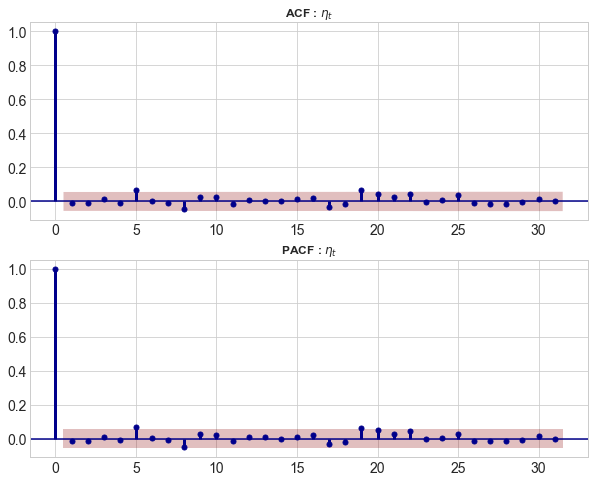

In [92]:
Var_eta = variance_model.resid/variance_model.conditional_volatility
AcfPacf(Var_eta, ' : '+r'$\eta_t$')

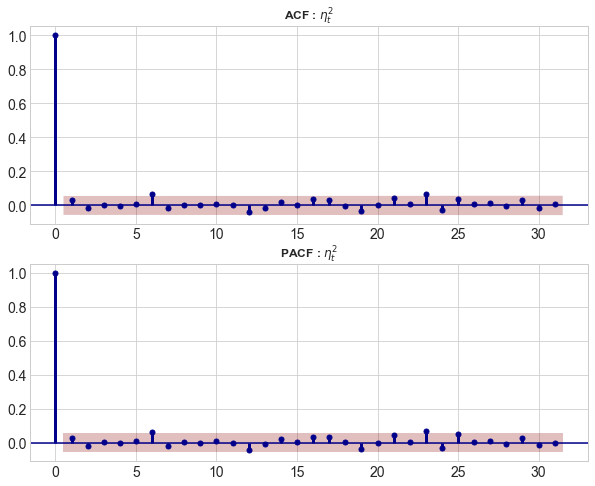

In [98]:
AcfPacf(Var_eta**2, ' : '+r'$\eta_t^2$')

In [124]:
lj = sm.stats.diagnostic.acorr_ljungbox(Var_eta, lags=6, return_df=True)
test_arch=het_arch(Var_eta)
name=["LM","LM p-value", "F", "F p-value"]
res_arch=pd.Series(test_arch, index=name)
print('Ljung-Box test \n------------------\n\n',lj, '\n\nARCH-LM test\n------------------\n\n', res_arch)

Ljung-Box test 
------------------

     lb_stat  lb_pvalue
1  0.174671   0.675994
2  0.315092   0.854237
3  0.494548   0.920088
4  0.568601   0.966488
5  6.590343   0.252932
6  6.593103   0.360119 

ARCH-LM test
------------------

 LM            22.306460
LM p-value     0.501821
F              0.968472
F p-value      0.504421
dtype: float64


In [147]:
backtest_arch_spec = rugarch.ugarchspec(mean_model = ro.r('list(armaOrder=c(1,0), include.mean=F)'), variance_model = ro.r('list(model="sGARCH", garchOrder=c(1,1))'), distribution_model='std')
backtest_data = FloatVector(log_returns.values)
backtest_arch_fit = rugarch.ugarchfit(spec=backtest_arch_spec, data=backtest_data)

In [148]:
base.print(backtest_arch_fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
ar1     0.086297    0.030252   2.8526 0.004336
omega   0.000004    0.000001   3.7696 0.000163
alpha1  0.168253    0.025238   6.6666 0.000000
beta1   0.744594    0.024694  30.1529 0.000000
shape   4.694708    0.523305   8.9713 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
ar1     0.086297    0.032629   2.6448 0.008173
omega   0.000004    0.000002   1.9617 0.049800
alpha1  0.168253    0.031388   5.3603 0.000000
beta1   0.744594    0.050519  14.7388 0.000000
shape   4.694708    0.729334   6.4370 0.000000

LogLikelihood : 4629.911 

Information Criteria
------------------------------------
                 

<rpy2.robjects.methods.RS4 object at 0x131de1d00> [RTYPES.S4SXP]
R classes: ('uGARCHfit',)

### Rolling Window Estimates and forecasts

In [284]:
str(log_returns.index[1241-400])

'2019-11-15 00:00:00'

** For the : AR(1)-GARCH(1,1) model**

In [285]:
rolling_garch_forecast = rugarch.ugarchroll(spec= backtest_arch_spec, n_ahead = 1, n_start=1241-400, refit_every=1, refit_window = 'moving', data=backtest_data)

In [286]:
with localconverter(ro.default_converter + pandas2ri.converter):
  outs_for = ro.conversion.rpy2py(rolling_arch_forecast.slots['forecast'][1])

In [287]:
outs_for.index=log_returns.loc['2019-11-15':].index

In [288]:
# Shape parameters
qs=[]
for i in range(outs_for.shape[0]):
    qs.append(rugarch.qdist(distribution='std', p=0.05, shape=FloatVector(outs_for['Shape'])))

In [289]:
VaR_GARCH = pd.Series(outs_for['Mu'].values + outs_for['Sigma'].values*np.array(qs[0]), index=outs_for.index)

** For the : EWMA model with $\beta=0.94$**

In [290]:
T = len(log_returns)
WE = T-400
beta =  0.94
sigma = (log_returns[:WE]**2).ewm(alpha=1.-0.94).mean()[-1]
VaR_EWMA = []
intervals = [(t - WE, t) for t in range(WE, T)]
for bounds in intervals:
    t1, t2 = bounds
    window = log_returns[t1:t2]
    sigma = (window**2).ewm(alpha=1.-0.94).mean()[-1]
    sigma = beta * sigma + (1-beta) * (window[-1])**2
    VaR_EWMA.append(stats.norm.ppf(0.05)*np.sqrt(sigma))
    
VaR_EWMA=pd.Series(VaR_EWMA, index=log_returns.loc['2019-11-15':].index)

In [291]:
RESULTS = pd.concat([log_returns.loc['2019-11-15':],VaR_GARCH,VaR_EWMA], axis=1)
RESULTS.columns = ['lrets', 'VaR_GARCH', 'VaR_EWMA']

In [293]:
fails_GARCH = RESULTS[RESULTS['lrets'] <= RESULTS['VaR_GARCH']]['lrets']
fails_EWMA = RESULTS[RESULTS['lrets'] <= RESULTS['VaR_EWMA']]['lrets']

Saving figure GARCH_approach 




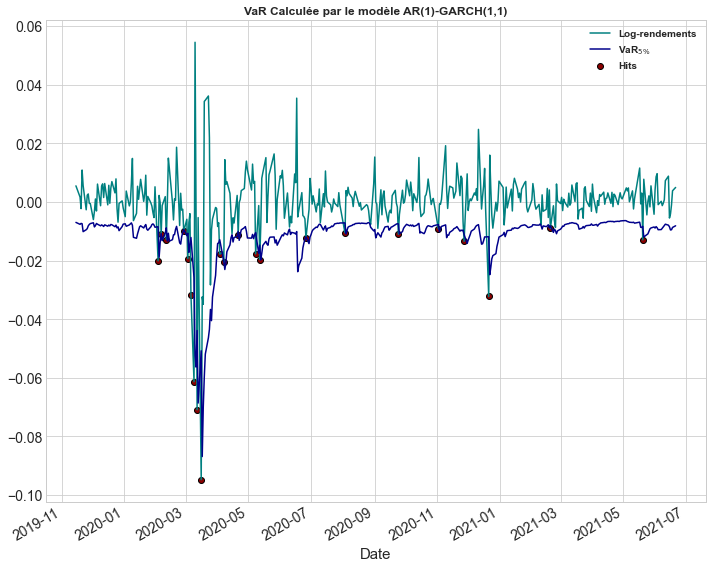

In [311]:
RESULTS[['lrets','VaR_GARCH']].plot(color=['teal','darkblue'] )
plt.scatter(fails_GARCH.index, fails_GARCH.values, edgecolors='black', facecolor='darkred')
plt.legend(['Log-rendements', r'VaR$_{5\%}$', 'Hits'], prop={'weight':'bold'})
plt.title('VaR Calculée par le modèle AR(1)-GARCH(1,1)', fontdict={'weight':'bold'})
save_fig('GARCH_approach')

Saving figure EWMA_approach 




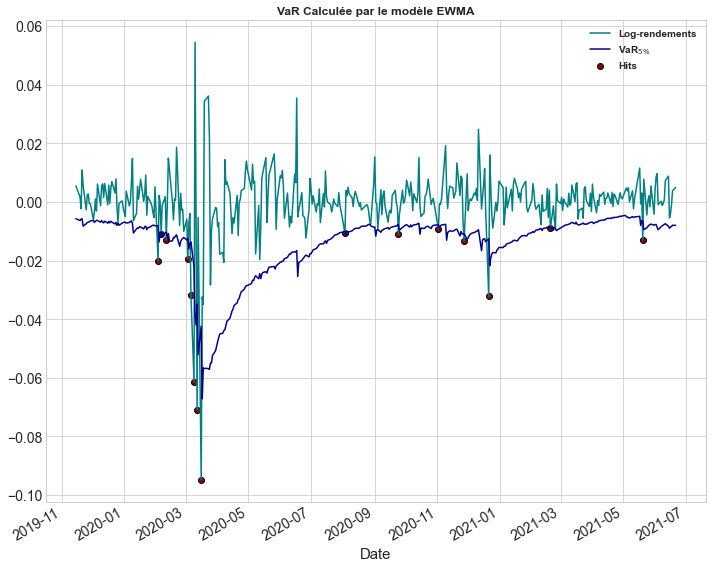

In [313]:
RESULTS[['lrets','VaR_EWMA']].plot(color=['teal','darkblue'] )
plt.scatter(fails_EWMA.index, fails_EWMA.values, edgecolors='black', facecolor='darkred')
plt.legend(['Log-rendements', r'VaR$_{5\%}$', 'Hits'], prop={'weight':'bold'})
plt.title('VaR Calculée par le modèle EWMA', fontdict={'weight':'bold'})
save_fig('EWMA_approach')

Saving figure all 




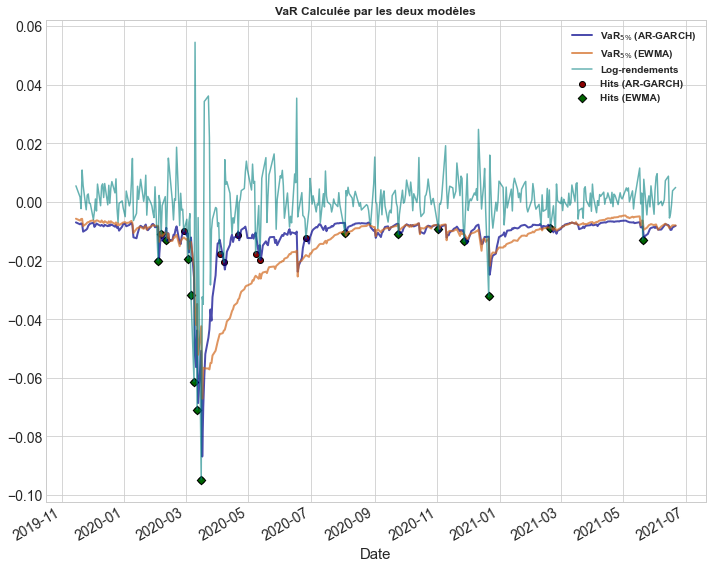

In [332]:
RESULTS[['VaR_GARCH','VaR_EWMA']].plot(color=['darkblue', 'chocolate'], alpha=0.7, linewidth=2)
plt.plot(RESULTS['lrets'], color='teal', alpha=0.6)
plt.scatter(fails_GARCH.index, fails_GARCH.values, edgecolors='black', facecolor='darkred')
plt.scatter(fails_EWMA.index, fails_EWMA.values, edgecolors='black', facecolor='darkgreen', marker='D')
plt.legend([ r'VaR$_{5\%}$ (AR-GARCH)', r'VaR$_{5\%}$ (EWMA)','Log-rendements','Hits (AR-GARCH)', 'Hits (EWMA)'], prop={'weight':'bold'})
plt.title('VaR Calculée par les deux modèles', fontdict={'weight':'bold'})
save_fig('all')

**Hits Ratios :** 

In [334]:
GARCH_RATIO = len(fails_GARCH)/400
EWMA_RATIO = len(fails_EWMA)/400

In [336]:
print('AR-GARCH RATIO : ',GARCH_RATIO, '\nEWMA RATIO : ', EWMA_RATIO )

AR-GARCH RATIO :  0.055 
EWMA RATIO :  0.0375


In [343]:
def Kupiec(ratio, WT, alpha):
    L_C = WT * ((1-ratio)*np.log(1-alpha) + ratio*np.log(alpha)) 
    L_UC = WT * ((1-ratio)*np.log(1-ratio) + ratio*np.log(ratio)) 
    LR = -2*(L_C - L_UC)
    LR_pval = stats.chi2.sf(LR, df=1)
    return LR, LR_pval

In [345]:
Kupiec(GARCH_RATIO, 400, 0.05)

(0.633507985630331, 0.42607147394208844)

In [346]:
Kupiec(EWMA_RATIO, 400, 0.05)

(4.452213564838871, 0.03485603797278932)